# Enter State Farm

In [1]:
from theano.sandbox import cuda
cuda.use('gpu1')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): Ignoring call to use(1), GPU number 0 is already in use.


In [2]:
%matplotlib inline
from __future__ import print_function, division
#path = "data/state/"
path = "/home/ubuntu/kaggle/statefarm/data/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

Using Theano backend.


In [3]:
batch_size=64

### Single conv layer

In [4]:
def conv1(batches):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ])

    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.0001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=8, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model

In [5]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
model = conv1(batches)

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/4
1500/1500 [==============================] - 42s - loss: 1.6798 - acc: 0.5760 - val_loss: 4.9465 - val_acc: 0.1380

In [6]:
model.optimizer.lr = 1e-5
model.fit_generator(batches, batches.nb_sample, nb_epoch=8, validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample)

Epoch 1/8
1500/1500 [==============================] - 41s - loss: 0.0016 - acc: 1.0000 - val_loss: 2.5216 - val_acc: 0.2630

In [7]:
model.optimizer.lr = 1e-6
model.fit_generator(batches, batches.nb_sample, nb_epoch=8, validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample)

Epoch 1/8
1500/1500 [==============================] - 40s - loss: 8.4345e-04 - acc: 1.0000 - val_loss: 1.7369 - val_acc: 0.4650

## Data augmentation

In [10]:
gen_t = image.ImageDataGenerator(rotation_range=12, width_shift_range=0.1, height_shift_range=0.025, 
                                 shear_range=0.15, zoom_range=0.1, channel_shift_range=20, fill_mode='constant')
batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 1500 images belonging to 10 classes.


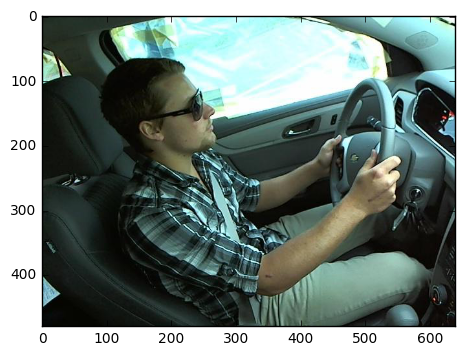

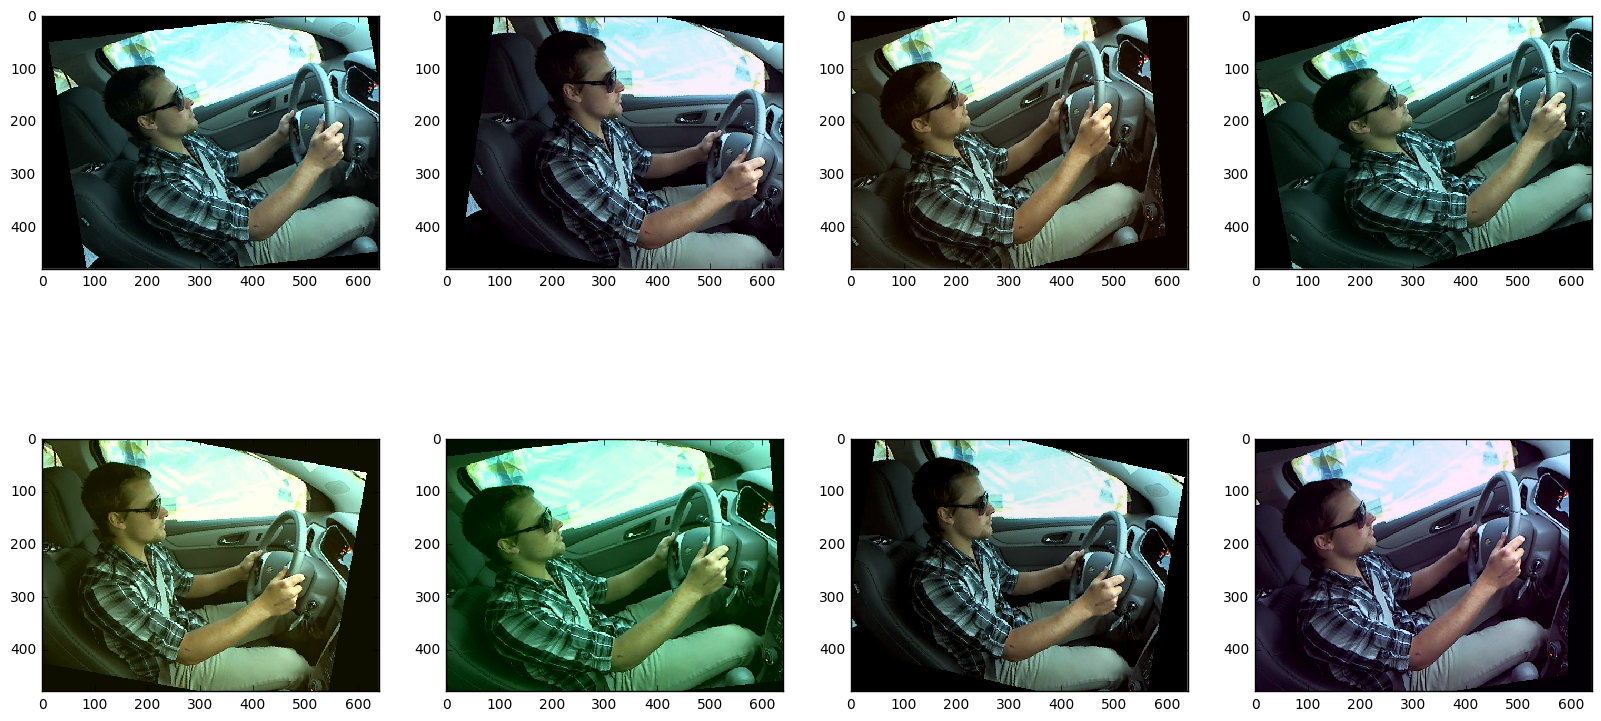

In [11]:
img = ndimage.imread(path+'train/c0/img_21618.jpg')
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img,0)
aug_iter = gen_t.flow(img)
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
aug_imgs = [np.transpose(aug_img, (1,2,0)) for aug_img in aug_imgs]
plt.imshow(np.transpose(img[0],(1,2,0)))
plots(aug_imgs, (20,10), 2)

In [12]:
batches = get_batches(path+'train', gen_t, batch_size=batch_size)
model = conv1(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/4
1500/1500 [==============================] - 41s - loss: 2.3171 - acc: 0.2933 - val_loss: 3.8743 - val_acc: 0.1990

In [13]:
model.optimizer.lr = 1e-4
model.fit_generator(batches, batches.nb_sample, nb_epoch=8, validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample)

Epoch 1/8
1500/1500 [==============================] - 42s - loss: 0.3583 - acc: 0.8920 - val_loss: 1.7579 - val_acc: 0.4570

In [14]:
model.optimizer.lr = 1e-5
model.fit_generator(batches, batches.nb_sample, nb_epoch=8, validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample)

Epoch 1/8
1500/1500 [==============================] - 42s - loss: 0.2119 - acc: 0.9340 - val_loss: 1.4916 - val_acc: 0.5800

## Time taken to precompute vgg features on sample

In [8]:
vgg = Vgg16()
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(path+'train', batch_size=batch_size, target_size=(224, 224))
import time
start_time = time.time()
conv_feat = conv_model.predict_generator(batches, batches.nb_sample)
end_time = time.time()
print(end_time-start_time)

Found 1500 images belonging to 10 classes.
42.1723918915


## Time taken to precompute vgg features on sample

In [9]:
path = "/home/ubuntu/kaggle/statefarm/data/"
vgg = Vgg16()
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(path+'train', batch_size=batch_size, target_size=(224, 224))
import time
start_time = time.time()
conv_feat = conv_model.predict_generator(batches, batches.nb_sample)
end_time = time.time()
print(end_time-start_time)

Found 20187 images belonging to 10 classes.
535.089430094
